In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import emoji
import math
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

C:\Users\Alec\AppData\Roaming\Python\Python37\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
#Read the data
dtypes = {
    'article_host': 'str', 
    'article_name': 'str', 
    'article_subtitle': 'str', 
    'hashtags': 'object',
    'img-label': 'str', 
    'img_src': 'str', 
    'linked_profiles': 'object', 
    'links': 'object', 
    'text': 'str', 
    'text_tokenized': 'object', 
    'text_tokenized_filtered': 'object',
    'text_tokenized_lemmatized': 'object', 
    'page_name': 'category', 
    'page_name_adjusted': 'category',
    'text_length': 'int32', 
    'wc': 'int32', 
    'sc': 'int32',
    'sixltr': 'int32'
}
pages = pd.read_csv('Data_Clean/pages.csv')
posts = pd.read_csv('Data_Clean/posts_full.csv', index_col=False, dtype=dtypes, 
                    parse_dates=['timestamp']).drop('Unnamed: 0', axis=1)
posts.head()

,article_host,article_name,article_subtitle,hashtags,img-label,img_src,linked_profiles,links,text,timestamp,...,work,achiev,leisure,home,money,relig,death,assent,nonflu,filler
0,vaxopedia.org,Is the CDC Pushing Vaccines Because a Batch of...,Guess when the latest batches of MMR expire?,[],No photo description available.,./About Pediatrics and Parenting Advice - Post...,NaN,[],The latest conspiracy theory is that MMR vacci...,2019-03-31 16:29:00,...,0.275862,0.103448,0.241379,0.068966,0.103448,0.241379,0.034483,0.068966,0.068966,0.00
1,keepkidshealthy.com,The New Vaccine Surveillance Network Report on...,Anyone who has been following the outbreaks of...,[],Sadio Mane has revealed he hates watching Man ...,./About Pediatrics and Parenting Advice - Post...,NaN,[],The New Vaccine Surveillance Network Report on...,2019-03-28 13:07:00,...,0.300000,0.100000,0.200000,0.100000,0.100000,0.200000,0.100000,0.100000,0.000000,0.00
2,sccgov.org,Public Health Department Warns of Possible Mea...,The County of Santa Clara Public Health Depart...,['measles'],NaN,NaN,NaN,[],"Someone with in Santa Clara County, #Californ...",2019-03-27 14:36:00,...,0.080000,0.080000,0.160000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.00
3,vaxopedia.org,News on the Latest Measles Outbreaks of 2019,Get vaccinated and stop the measles outbreaks.,[],Image may contain: one or more people and peop...,./About Pediatrics and Parenting Advice - Post...,NaN,[],"There are 33 new measles cases in Brooklyn, br...",2019-03-27 14:14:00,...,0.214286,0.142857,0.250000,0.035714,0.107143,0.071429,0.035714,0.000000,0.000000,0.00
4,vaxopedia.org,The CDC Vaccine Price List Conspiracy,Did you believe this one?,[],No photo description available.,./About Pediatrics and Parenting Advice - Post...,NaN,[],It took less a few minutes to debunk the lates...,2019-03-27 13:32:00,...,0.150000,0.150000,0.200000,0.100000,0.100000,0.150000,0.100000,0.050000,0.000000,0.05


### Data Preparation

In [3]:
#Linked_profiles were written as NaN if empty
posts['linked_profiles'] = posts.linked_profiles.fillna('[]')
#Change list columns to lists
list_cols = ['hashtags', 'links', 'linked_profiles', 'text_tokenized', 
             'text_tokenized_filtered', 'text_tokenized_lemmatized']
for col in list_cols:
    posts[col] = posts[col].apply(eval)

### More Features

In [4]:
posts['num_emojis'] = posts.text_tokenized.apply(lambda x: len([e for e in x if e in emoji.UNICODE_EMOJI]))

### Data Cleaning

In [5]:
#Scale 'num_' features by number of words
unneeded_percs = set(['num_' + '_'.join(c.split('_')[1:]) for c in posts.columns if c.startswith('percent_')])
skip_percs = {'num_words', 'num_tokens'}
for nc in [n for n in posts.columns if n.startswith('num_') and n not in unneeded_percs.union(skip_percs)]:
    replacement = (posts[nc] / posts.num_words).apply(lambda x: x if not math.isinf(x) else 0)
    posts['percent_' + '_'.join(nc.split('_')[1:])] = replacement
    posts.drop(nc, axis=1, inplace=True)

# Data Visualization

In [6]:
#Describe the data
posts.describe()

,text_length,num_tokens,num_words,num_periods,percent_periods,num_exclamations,percent_exclamations,num_questionms,percent_questionms,num_equals,...,percent_pos_RBS,percent_pos_UH,percent_pos_VB,percent_pos_RB,percent_pos_MD,percent_pos_JJS,percent_pos_'',percent_pos_WP$,percent_pos_VBZ,percent_emojis
count,89867.000000,89867.000000,89867.000000,89867.000000,74004.000000,89867.000000,74004.000000,89867.000000,74004.000000,89867.000000,...,73487.000000,73487.000000,73487.000000,73487.000000,73487.000000,73487.000000,73487.000000,73487.000000,73487.000000,73640.000000
mean,297.659886,57.433207,30.724237,2.101405,0.035731,0.509353,0.021115,0.318549,0.011635,0.005208,...,0.000311,0.000482,0.050262,0.047940,0.008301,0.002014,0.000009,0.000129,0.006441,0.009727
std,791.157134,149.605620,82.930137,6.378089,0.050014,1.431003,0.057351,1.171465,0.037988,0.147289,...,0.004756,0.013156,0.083157,0.077789,0.032064,0.014716,0.000877,0.003129,0.022154,0.076126
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,109.000000,22.000000,12.000000,1.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.021127,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,284.000000,54.000000,29.000000,2.000000,0.050000,1.000000,0.016393,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,40244.000000,6323.000000,5152.000000,232.000000,1.000000,60.000000,1.000000,97.000000,1.000000,19.000000,...,0.250000,0.750000,1.000000,1.000000,1.000000,0.500000,0.111111,0.500000,0.333333,3.000000


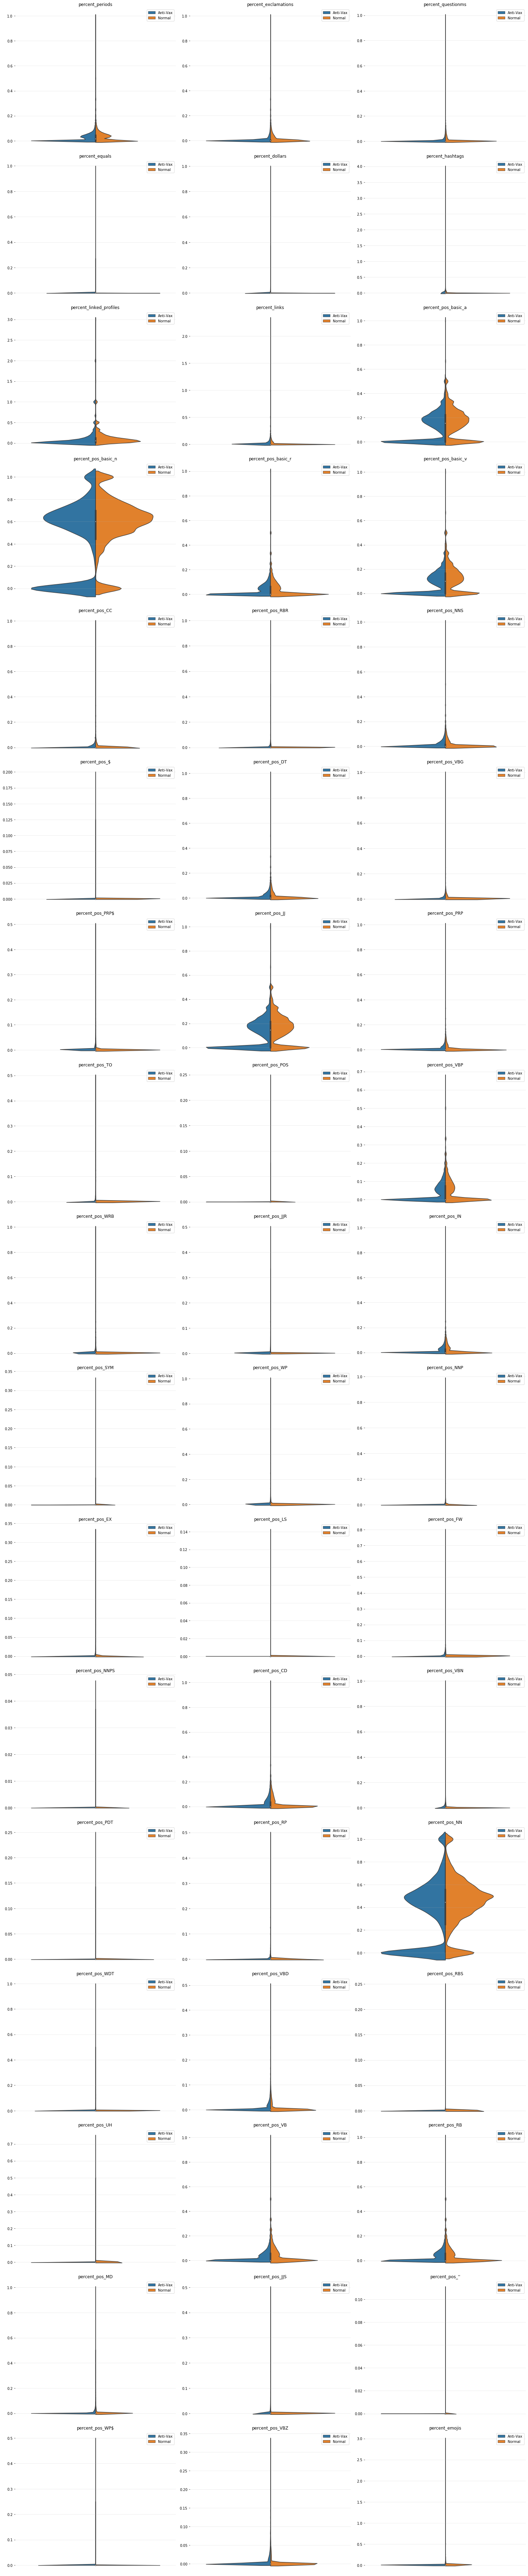

In [16]:
#Plot all numerical data
def plot_comparison_violins(df, ncols=3, figsize=None, filename='Violin Comparisons.png'):
    num = df.select_dtypes(['float64', 'int64', 'int16']).fillna(0)
    num['anti_vax'] = df.anti_vax.apply(lambda x: 'Anti-Vax' if x else 'Normal').astype('category')
    nrows = int(np.ceil(len(num.columns[:-1]) / ncols))
    blank = np.zeros(num.shape[0])
    if not figsize:
        figsize=(21, 6 * nrows)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for i, col in enumerate(num.columns[:-1]):
        ax = None
        if ncols * nrows == 1:
            ax = axes
        else:
            ax = axes[int(i / ncols), i % ncols]
        sns.violinplot(x=blank, y=col, hue='anti_vax', data=num, split=True, ax=ax, orient='v', legend=False)
        ax.xaxis.set_visible(False)
        ax.legend()
        ax.set_title(col)
        ax.set_ylabel('')
        ax.yaxis.grid(True, alpha=0.3)
        for g in ax.spines:
            ax.spines[g].set_visible(False)
    for i in range(len(num.columns) - 1, nrows * ncols):
        fig.delaxes(axes[int(i / ncols), i % ncols])
    fig.tight_layout()
    fig.savefig(filename, bbox_inches='tight')
plot_comparison_violins(posts[[c for c in posts.columns if c.startswith('percent_') or c == 'anti_vax']])

In [8]:
#Scale the data normally
scaler = StandardScaler()
numerical_posts = posts.select_dtypes(['float64', 'float32', 'int64', 'int16', 'int32', 'bool']
                                     ).drop('anti_vax', axis=1).fillna(0)
scaled = pd.DataFrame(scaler.fit_transform(numerical_posts), columns=numerical_posts.columns)

C:\Users\Alec\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype bool, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Alec\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype bool, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
#Run PCA on scaled data
pca = PCA(n_components=2)
decomposed = pca.fit_transform(scaled)
pca_df = pd.DataFrame(decomposed, columns=['x', 'y'])
pca_df['anti_vax'] = posts.anti_vax.apply(lambda x: 'Anti-vax' if x else 'Normal').astype('category')

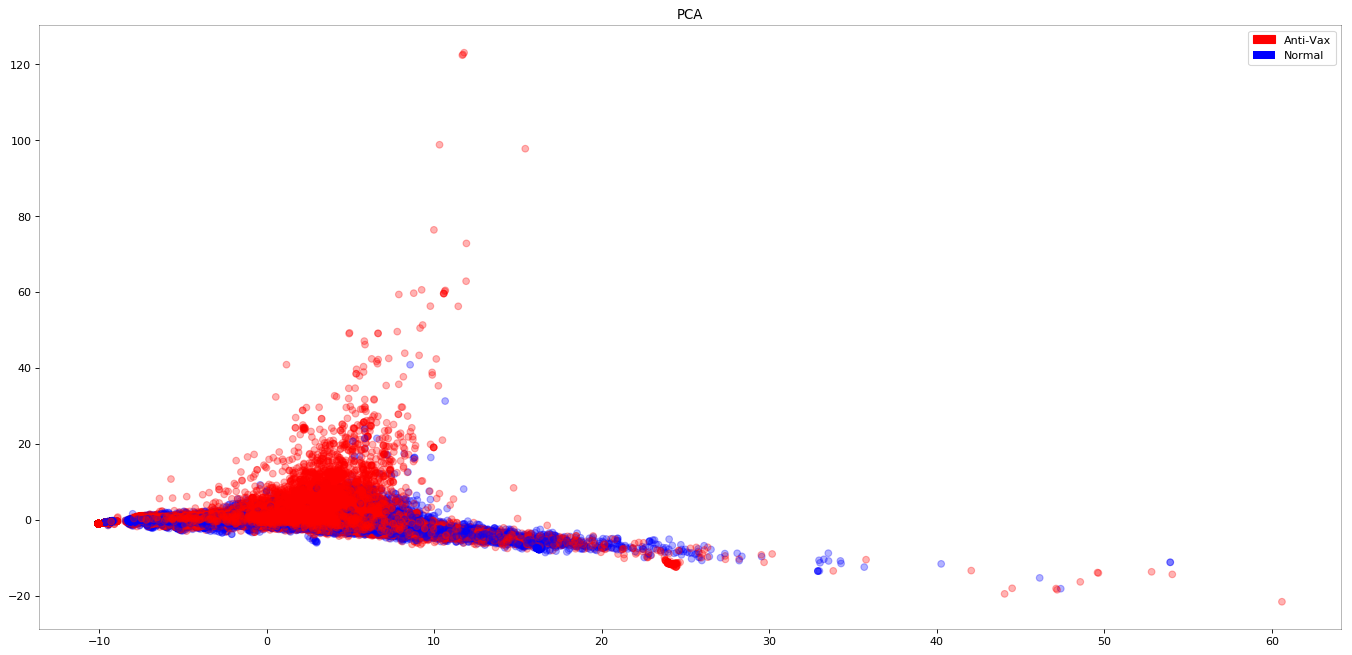

In [10]:
#Plot PCA
from matplotlib.patches import Patch
plt.figure(figsize=(21, 10), dpi=80)
path = plt.scatter(pca_df.x, pca_df.y, c=pca_df.anti_vax.apply(lambda x: 'red' if x == 'Anti-vax' else 'blue'), 
                   alpha=0.3, cmap='bwr')
path.axes.set_title('PCA');
plt.legend(handles=[Patch(facecolor='red', edgecolor='r', label='Anti-Vax'), Patch(facecolor='blue', label='Normal')])
for g in path.axes.spines:
    path.axes.spines[g].set_alpha(0.3)
plt.savefig('PCA.png', bbox_inches='tight')

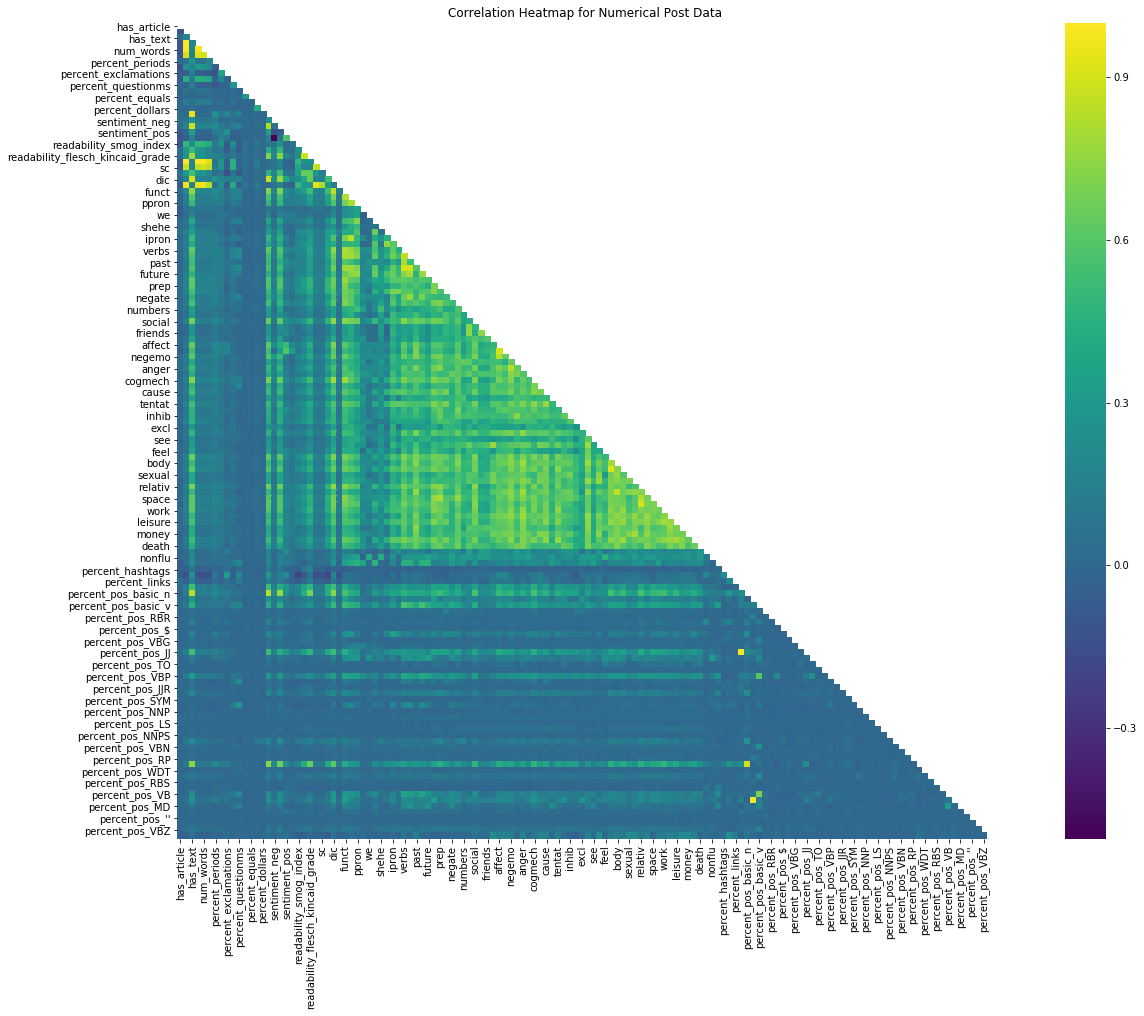

In [11]:
corr = scaled.corr()
fig, ax = plt.subplots(figsize=(26, 15))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, ax=ax, cmap='viridis', square=True)
ax.set_title('Correlation Heatmap for Numerical Post Data')
fig.savefig('Correlation Heatmap.png', bbox_inches='tight');

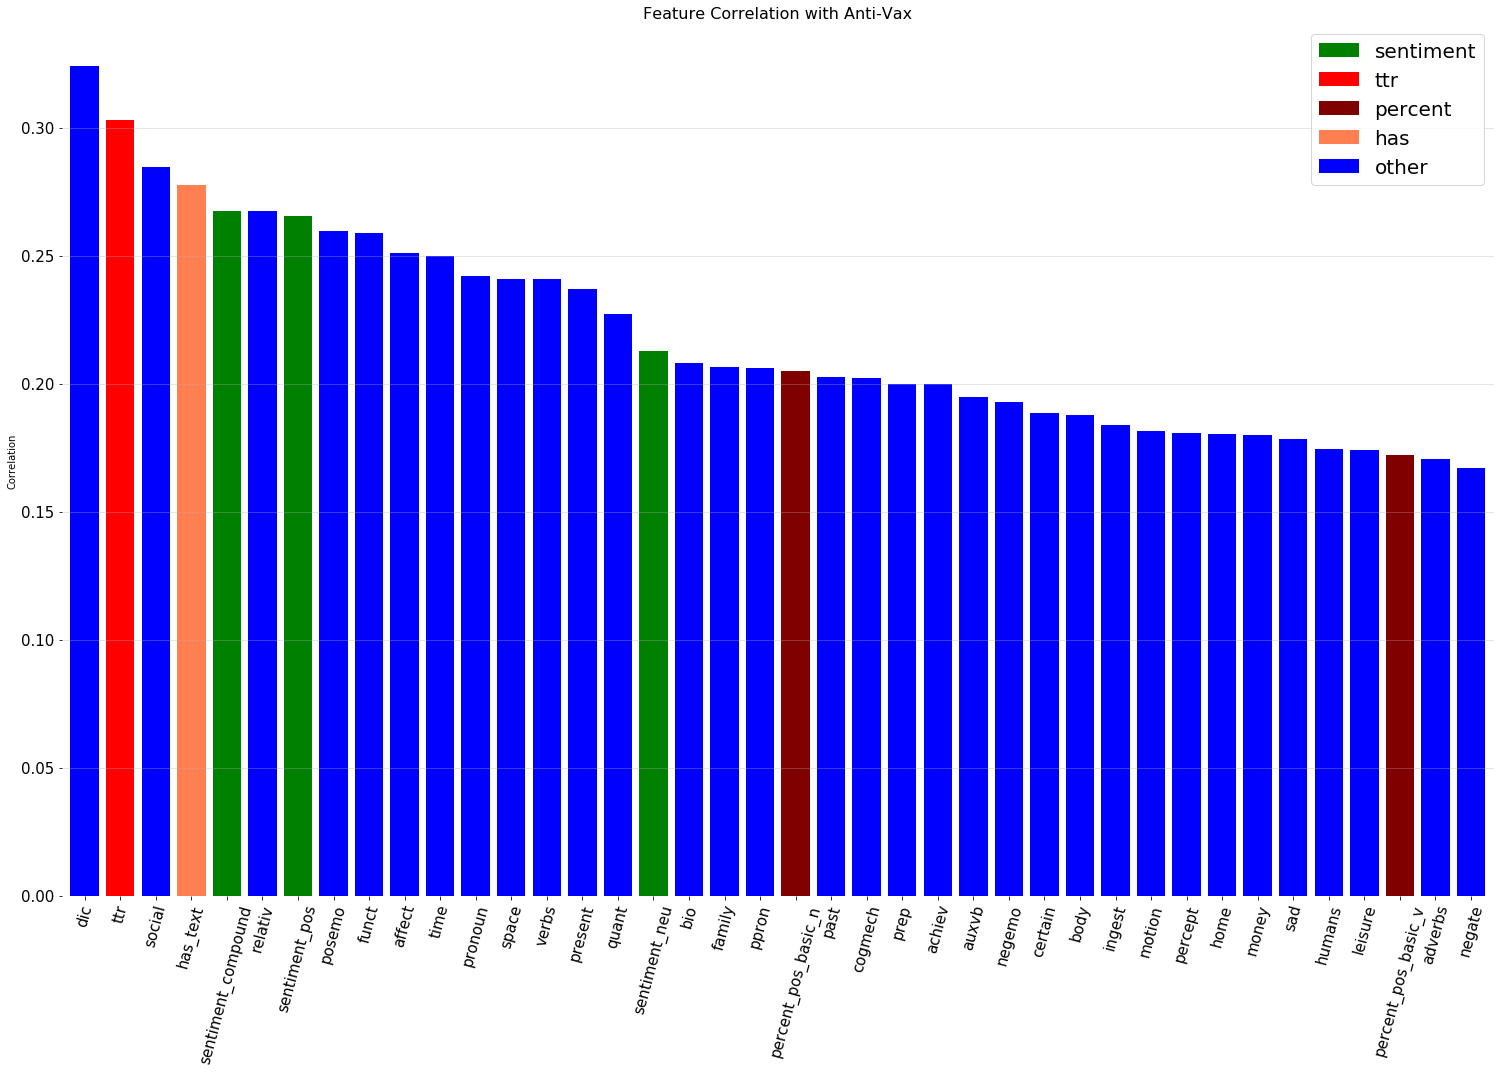

In [12]:
#Show correlation with Anti-Vax
feature_corr = scaled.corrwith(posts.anti_vax).abs().sort_values(ascending=False).head(40)

#Generate colors for the bars based upon where the features came from
color_categories = {'text_': 'black', 'num_pos': 'orange', 'num_': 'yellow', 'ttr': 'red', 'sentiment_': 'green', 
                        'percent_': 'maroon', 'readability_': 'lightgreen', 'has_': 'coral', 'other': 'blue'}
def generate_categories(col):
    for cc in color_categories:
        if col.startswith(cc):
            return cc
    return 'other'
column_cats = [generate_categories(c) for c in feature_corr.index]
column_colors = [color_categories[c] for c in column_cats]

#Legend for the plot
handles = []
for c in set(column_cats):
    handles.append(Patch(facecolor=color_categories[c], label=c.replace('_', '')))

fig, ax = plt.subplots(figsize=(21, 15))
feature_corr.plot.bar(ax=ax, width=0.8, rot=75, color=column_colors)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Feature Correlation with Anti-Vax', fontsize=16)
ax.set_ylabel('Correlation')
for g in ax.spines:
    ax.spines[g].set_visible(False)
ax.yaxis.grid(True, alpha=0.4)
ax.legend(handles=handles, prop={'size': 20})
fig.tight_layout()
fig.savefig('Feature Correlation', bbox_inches='tight');

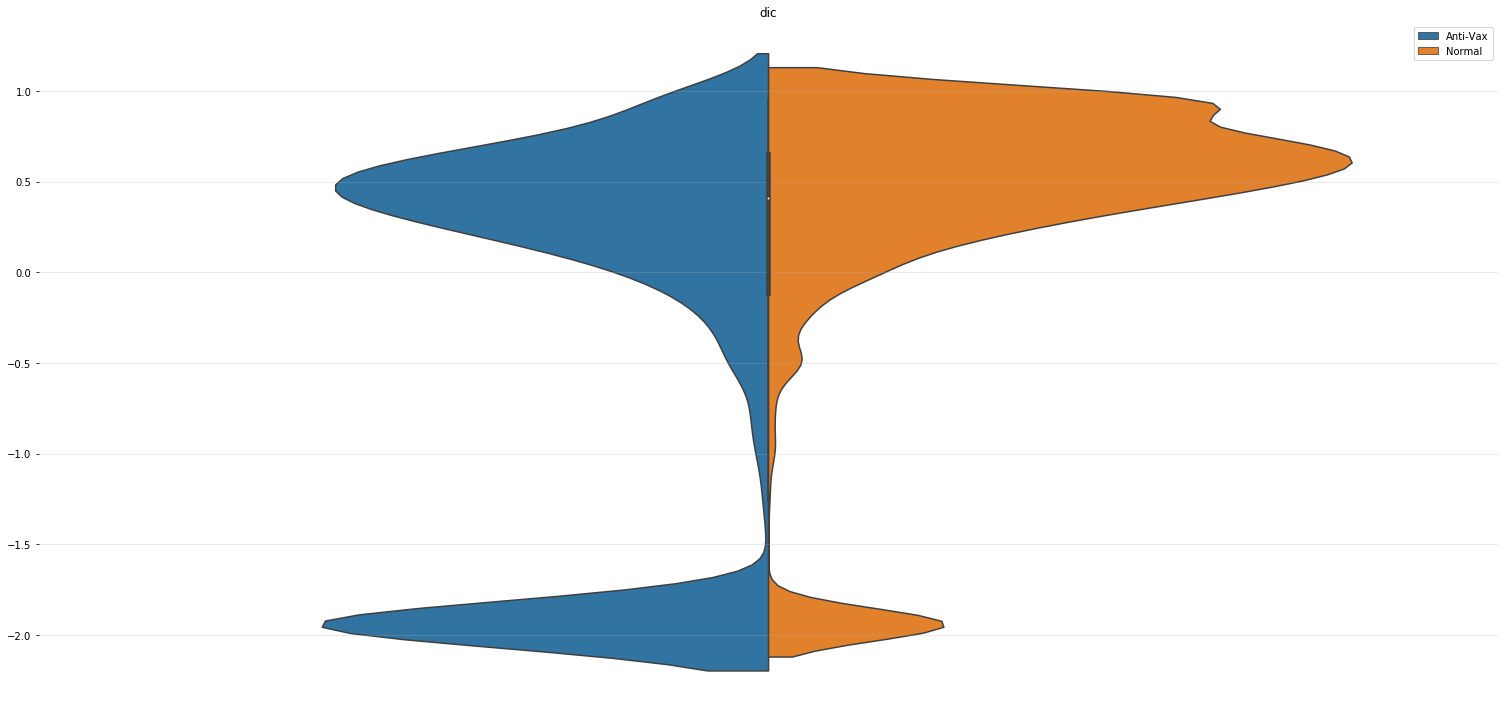

In [13]:
plot_comparison_violins(scaled[['dic']].join(posts.anti_vax), ncols=1, filename='DIC Comparison.png', figsize=(21, 10))

### Feature Variance Analysis

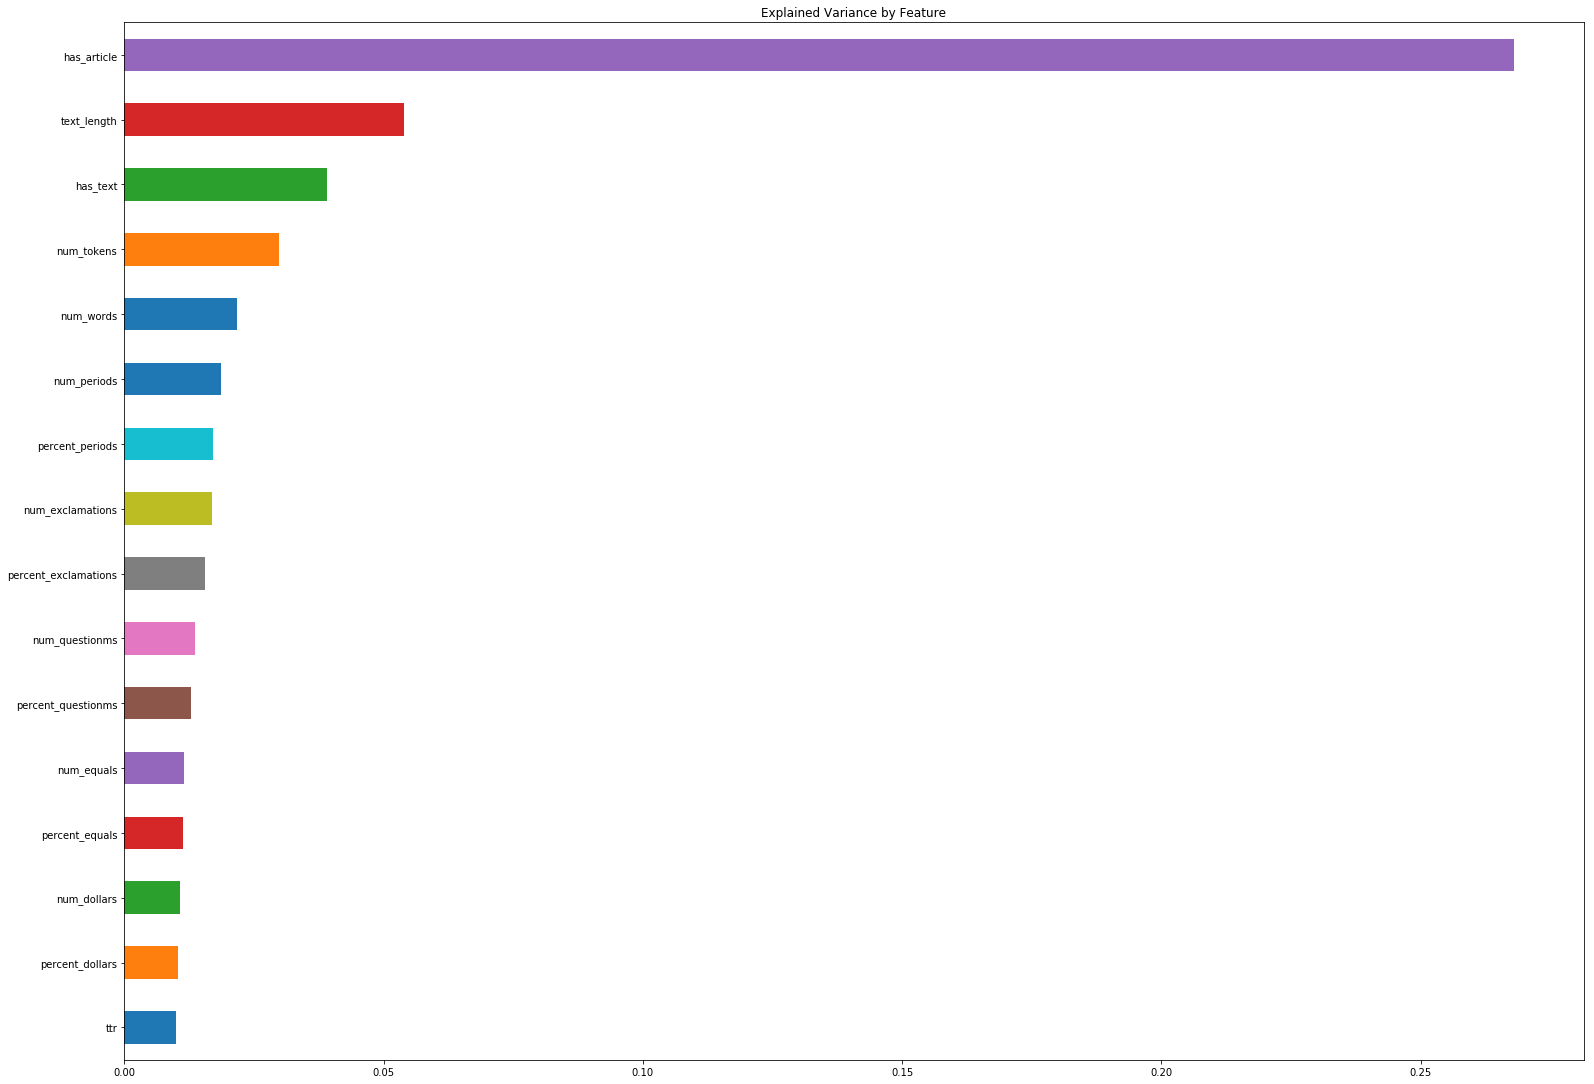

In [14]:
cov_pca = PCA(n_components=len(scaled.columns))
cov_pca.fit(scaled)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
explained_var = pd.Series(cov_pca.explained_variance_ratio_, index=scaled.columns).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(21, 15))
fig.tight_layout()
ax = explained_var[explained_var > 0.01].plot.barh(ax=ax)
ax.set_title('Explained Variance by Feature')
fig.savefig('Explained Variance.png', bbox_inches='tight');

In [26]:
explained_var[explained_var < 0.001]

percent_emojis     0.00000
percent_pos_VBZ    0.00000
percent_pos_WP$    0.00000
percent_pos_''     0.00000
percent_pos_JJS    0.00000
percent_pos_MD     0.00001
percent_pos_RB     0.00001
percent_pos_VB     0.00004
percent_pos_UH     0.00005
percent_pos_RBS    0.00006
percent_pos_VBD    0.00009
percent_pos_WDT    0.00012
percent_pos_NN     0.00014
percent_pos_RP     0.00016
percent_pos_PDT    0.00017
percent_pos_VBN    0.00023
percent_pos_CD     0.00024
percent_pos_NNPS   0.00025
percent_pos_FW     0.00028
percent_pos_LS     0.00034
percent_pos_EX     0.00036
percent_pos_NNP    0.00039
percent_pos_WP     0.00041
percent_pos_SYM    0.00047
percent_pos_IN     0.00053
percent_pos_JJR    0.00060
percent_pos_WRB    0.00064
percent_pos_VBP    0.00068
percent_pos_POS    0.00073
percent_pos_TO     0.00076
percent_pos_PRP    0.00079
percent_pos_JJ     0.00082
percent_pos_PRP$   0.00086
percent_pos_VBG    0.00087
percent_pos_DT     0.00090
percent_pos_$      0.00095
dtype: float64

In [ ]:
from fbdp import bigrams
bg = bigrams(posts);bg